In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Loading

In [2]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [3]:
X = data['Translated']
y = data['Label']

In [4]:
X

0      After hacking state TV by replacing propaganda...
1      #flowers #lovers\nMake love not war.\nMarc Cha...
2      If only we all showed more love and understand...
3      Who are the soldiers we see in the videos? Are...
4      I didn't think #Salvini could make his positio...
                             ...                        
475    If I write that Ms. #Zelensky was allegedly sp...
476    #Zelensky and his wife #OlenaZelenska bought a...
477    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
478    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
479    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
Name: Translated, Length: 480, dtype: object

In [5]:
y

0      1
1      2
2      2
3      2
4      1
      ..
475    1
476    0
477    2
478    2
479    2
Name: Label, Length: 480, dtype: int64

# Pretrained not Finetuned

## Load Bert

In [6]:
pretrained_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Generate Embeddings

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

def generate_sentence_embeddings(texts, tokenizer, model, batch_size=32):
    """
    Generate BERT embeddings for a list of sentences.

    Args:
        texts (list of str): List of input sentences.
        tokenizer: Pre-trained BERT tokenizer.
        model: Pre-trained BERT model.
        batch_size (int): Batch size for processing.
        device (str): Device to use ('cpu' or 'cuda').

    Returns:
        np.ndarray: Array of sentence embeddings (shape: [num_sentences, embedding_dim]).
    """
    model.to(device)
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)
            outputs = model(**inputs)
            pooled_output = outputs.pooler_output.cpu().numpy()
            embeddings.append(pooled_output)
    return np.vstack(embeddings)

In [9]:

# Split the data while preserving raw text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate embeddings for training and testing sets
print("Generating BERT embeddings...")
X_train_embeddings = generate_sentence_embeddings(X_train.tolist(), pretrained_tokenizer, pretrained_model)
X_test_embeddings = generate_sentence_embeddings(X_test.tolist(), pretrained_tokenizer, pretrained_model)

print('Done')

Generating BERT embeddings...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Done


## Train an SVM

In [10]:
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training SVM...
Accuracy: 41.67%


## View report

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.48        16
           1       0.17      0.20      0.18        20
           2       0.53      0.60      0.57        43
           3       0.33      0.12      0.17        17

    accuracy                           0.42        96
   macro avg       0.38      0.36      0.35        96
weighted avg       0.41      0.42      0.40        96



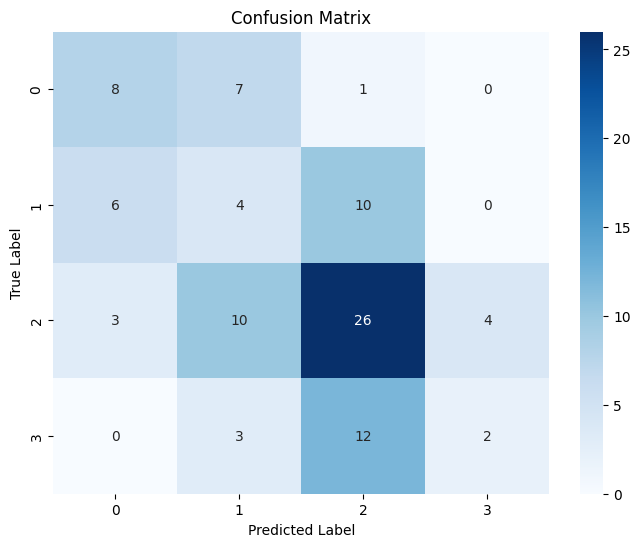

In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get unique class labels for plotting
class_labels = sorted(set(y_test))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## See misclassified sentences

In [12]:
misclassified_indices = np.where(y_test != y_pred)[0]

# Print misclassified sentences
print("Misclassified Sentences:")
for idx in misclassified_indices:
    print()
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}, Sentence: {X_test.iloc[idx]}")
    print('---')

Misclassified Sentences:

True Label: 3, Predicted Label: 2, Sentence: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
---

True Label: 1, Predicted Label: 2, Sentence: Countries supporting #Ukraine do not have the means to track the weapons they send to the Kiev army. And some have already gone to pro-Russian troops in the #Donbass, as some photos show 👇

by @FuturaDaprile

 
---

True Label: 1, Predicted Label: 0, Sentence: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
---

True Label: 2, Predicted Label: 1, Sentence: This #April25 I will go to the parade.
I had the honor of knowing that generation of #Liberals who took up arms to defend the Fatherland, and I know they would have no problem today recognizing the #partisans of that time in the Ukrainians and Ukrainians of

## Visualize the embeddings of the individual words

In [13]:
def generate_word_embeddings(text, tokenizer, model, device='cpu'):

    model.to(device)
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state  # Shape: (1, num_tokens, 768)
        embeddings = hidden_states.squeeze(0).cpu().numpy()  # Shape: (num_tokens, 768)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    return tokens, embeddings

def plot_word_embeddings(tokens, embeddings, reduction_method='pca'):

    # Step 1: Reduce dimensions to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(5, len(tokens) - 1))
        reduced_embeddings = reducer.fit_transform(embeddings)  # Shape: (num_tokens, 2)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca' or 'tsne'.")

    # Step 2: Plot the embeddings
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', alpha=0.7)

    # Annotate each point with its token
    for i, token in enumerate(tokens):
        plt.annotate(token, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)

    plt.xlabel(f'{reduction_method.upper()} Component 1')
    plt.ylabel(f'{reduction_method.upper()} Component 2')
    plt.title(f'2D Word Embedding Visualization ({reduction_method.upper()})')
    plt.grid()
    plt.show()

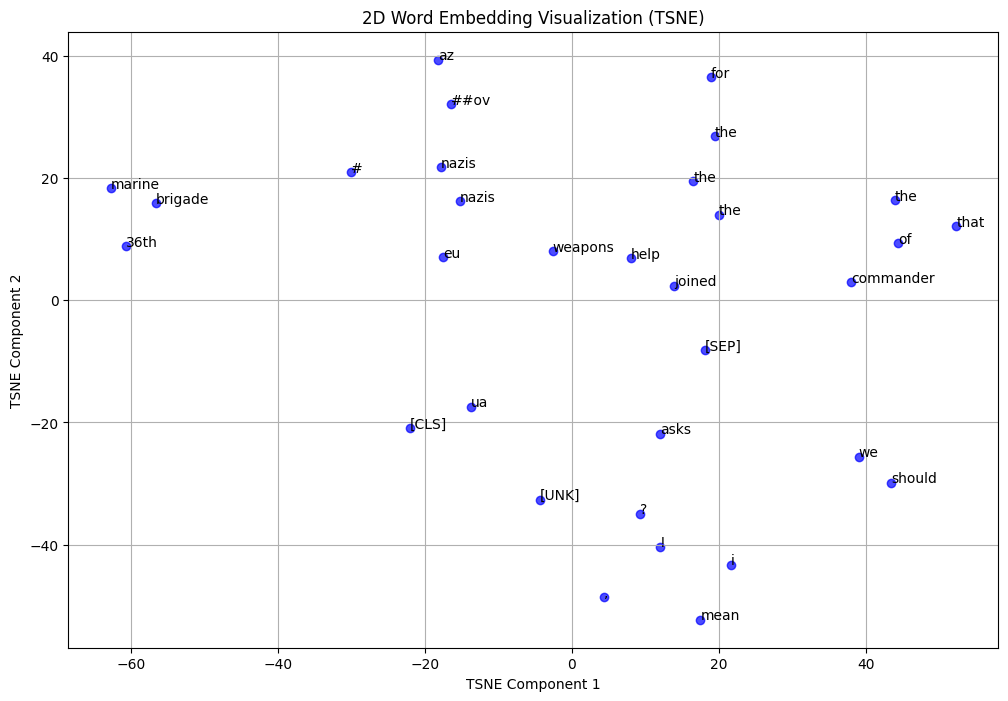

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
text = """UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
tokens, embeddings = generate_word_embeddings(text, pretrained_tokenizer, pretrained_model, device=device)
plot_word_embeddings(tokens, embeddings, reduction_method='tsne')

## Visualize the Embeddings

In [15]:
def plot_attention_scores(sentence, tokenizer, model, device='cpu', layer=0, head=0):

    # Step 1: Move the model to the specified device
    model.to(device)
    model.eval()

    # Step 2: Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )

    # Step 3: Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Step 4: Generate attention scores
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Tuple of attention tensors for all layers and heads

    # Step 5: Extract attention scores for the specified layer and head
    # Average attention scores across all heads in a layer
    attention_scores = attentions[layer].mean(dim=1)[0].cpu().numpy()
    
    # Average attention scores across all layers and heads
    attention_scores = torch.stack(attentions).mean(dim=(1, 2))[0].cpu().numpy()

    # Step 6: Get tokens for labeling
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Step 7: Plot attention scores as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f"Attention Scores (Layer {layer}, Head {head})")
    plt.xlabel("Keys (Tokens)")
    plt.ylabel("Queries (Tokens)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

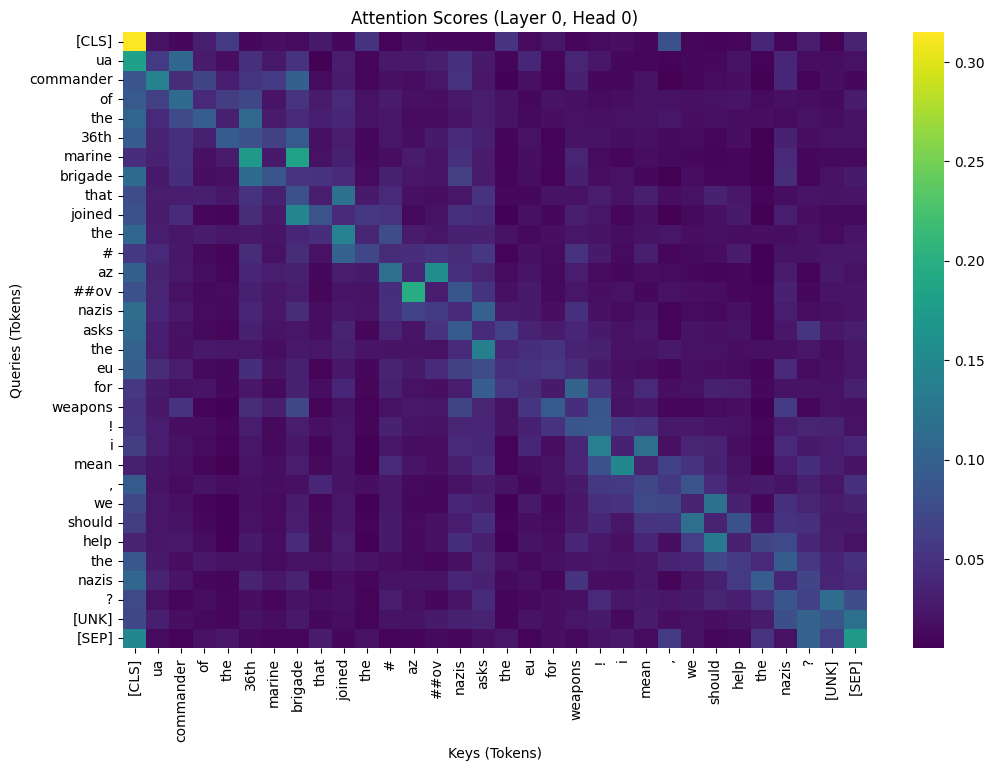

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sentence =""" UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!
I mean, we should help the Nazis?😳😮😱"""
plot_attention_scores(sentence, pretrained_tokenizer, pretrained_model, device=device, layer=0, head=0)

# Finetuning BERT

In [18]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    evaluation_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sentence = "UA commander of the 36th Marine brigade that joined the #Azov Nazis asks the EU for weapons!"
plot_attention_scores(sentence, tokenizer, model, device=device, layer=0, head=0)